<a href="https://colab.research.google.com/github/YichengZou626/COMP590_intro_to_deep_learning/blob/main/Homework_6_(Yicheng_Zou).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Batch normalization (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.
1. Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization. To do this, you will need to compute the gradient of the loss over some data with respect to each parameter, square these gradients, and sum the result across all parameters. You can compute this value at each training step, or after each epoch. What difference does batch normalization make in terms of the squared L2 norm of gradients?

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.003

In [ ]:
#image preprocessing
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
#download dataset and split into train and test 
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
# Convolution filter of 3x3
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    grads = 0
    for w in model.parameters():
      grad = w.grad.cpu().detach().numpy()
      grad = np.sum(np.sum(grad*grad))
      grads+=grad
    grads_list.append(grads)

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 1.6205
Epoch [1/30], Step [200/500] Loss: 1.6335
Epoch [1/30], Step [300/500] Loss: 1.5941
Epoch [1/30], Step [400/500] Loss: 1.2847
Epoch [1/30], Step [500/500] Loss: 1.2184
Epoch [2/30], Step [100/500] Loss: 1.0161
Epoch [2/30], Step [200/500] Loss: 0.8776
Epoch [2/30], Step [300/500] Loss: 1.0102
Epoch [2/30], Step [400/500] Loss: 0.9194
Epoch [2/30], Step [500/500] Loss: 1.1378
Epoch [3/30], Step [100/500] Loss: 0.8302
Epoch [3/30], Step [200/500] Loss: 0.8123
Epoch [3/30], Step [300/500] Loss: 1.1278
Epoch [3/30], Step [400/500] Loss: 0.8104
Epoch [3/30], Step [500/500] Loss: 0.9296
Epoch [4/30], Step [100/500] Loss: 0.8214
Epoch [4/30], Step [200/500] Loss: 0.8647
Epoch [4/30], Step [300/500] Loss: 0.6126
Epoch [4/30], Step [400/500] Loss: 0.6127
Epoch [4/30], Step [500/500] Loss: 0.6437
Epoch [5/30], Step [100/500] Loss: 0.7545
Epoch [5/30], Step [200/500] Loss: 0.7249
Epoch [5/30], Step [300/500] Loss: 0.6793
Epoch [5/30], Step [400/500] Loss:

Text(0.5, 1.0, 'gradient over training')

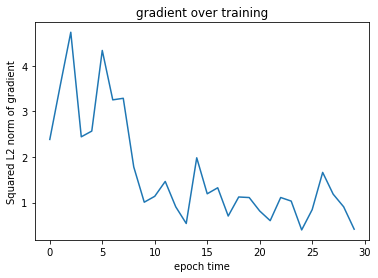

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(grads_list)), grads_list)

plt.xlabel('epoch time') 
plt.ylabel('Squared L2 norm of gradient') 
plt.title('gradient over training') 

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 87.98 %


Remove batch normalization and set learning rate as before (lr = 0.003)

In [ ]:
# remove batch normalization for each residual block
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        #self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        #self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        #out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        #self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        #out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.003
model_noBN = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_noBN.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_noBN(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    grads = 0
    for w in model_noBN.parameters():
      grad = w.grad.cpu().detach().numpy()
      grad = np.sum(np.sum(grad*grad))
      grads+=grad
    grads_list.append(grads)

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 2.0425
Epoch [1/30], Step [200/500] Loss: 1.9358
Epoch [1/30], Step [300/500] Loss: 1.8664
Epoch [1/30], Step [400/500] Loss: 1.5726
Epoch [1/30], Step [500/500] Loss: 1.6262
Epoch [2/30], Step [100/500] Loss: 1.6827
Epoch [2/30], Step [200/500] Loss: 1.6160
Epoch [2/30], Step [300/500] Loss: 1.5613
Epoch [2/30], Step [400/500] Loss: 1.4260
Epoch [2/30], Step [500/500] Loss: 1.3880
Epoch [3/30], Step [100/500] Loss: 1.2334
Epoch [3/30], Step [200/500] Loss: 1.1873
Epoch [3/30], Step [300/500] Loss: 1.2527
Epoch [3/30], Step [400/500] Loss: 1.2804
Epoch [3/30], Step [500/500] Loss: 1.2841
Epoch [4/30], Step [100/500] Loss: 1.0852
Epoch [4/30], Step [200/500] Loss: 1.2039
Epoch [4/30], Step [300/500] Loss: 1.3821
Epoch [4/30], Step [400/500] Loss: 1.1375
Epoch [4/30], Step [500/500] Loss: 1.2564
Epoch [5/30], Step [100/500] Loss: 1.3074
Epoch [5/30], Step [200/500] Loss: 1.2051
Epoch [5/30], Step [300/500] Loss: 1.0445
Epoch [5/30], Step [400/500] Loss:

Text(0.5, 1.0, 'gradient over training without BN lr=0.003')

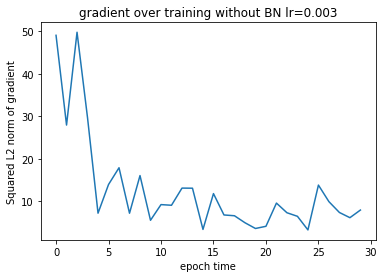

In [ ]:
plt.plot(np.arange(len(grads_list)), grads_list)

plt.xlabel('epoch time') 
plt.ylabel('Squared L2 norm of gradient') 
plt.title('gradient over training without BN lr=0.003') 

In [ ]:
# Test the model
model_noBN.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_noBN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 80.31 %


The graph shows that after removing batch normalization, the squared L2 norm of gradient will be much larger than previous one. That indicates the effect of batch normalization to help reduce the variance in the dataset. Also, the accuracy of model decreased after removing batch normalization.

Next, increase learning rate to 0.01

In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.01
model_noBN = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_noBN.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_noBN(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    grads = 0
    for w in model_noBN.parameters():
      grad = w.grad.cpu().detach().numpy()
      grad = np.sum(np.sum(grad*grad))
      grads+=grad
    grads_list.append(grads)

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 2.3033
Epoch [1/30], Step [200/500] Loss: 2.1930
Epoch [1/30], Step [300/500] Loss: 2.0378
Epoch [1/30], Step [400/500] Loss: 2.0305
Epoch [1/30], Step [500/500] Loss: 1.9654
Epoch [2/30], Step [100/500] Loss: 2.0487
Epoch [2/30], Step [200/500] Loss: 1.7649
Epoch [2/30], Step [300/500] Loss: 1.8436
Epoch [2/30], Step [400/500] Loss: 1.8379
Epoch [2/30], Step [500/500] Loss: 1.7474
Epoch [3/30], Step [100/500] Loss: 1.8816
Epoch [3/30], Step [200/500] Loss: 1.7798
Epoch [3/30], Step [300/500] Loss: 1.8718
Epoch [3/30], Step [400/500] Loss: 1.8767
Epoch [3/30], Step [500/500] Loss: 1.6826
Epoch [4/30], Step [100/500] Loss: 1.6422
Epoch [4/30], Step [200/500] Loss: 1.6698
Epoch [4/30], Step [300/500] Loss: 1.7337
Epoch [4/30], Step [400/500] Loss: 1.5905
Epoch [4/30], Step [500/500] Loss: 1.6475
Epoch [5/30], Step [100/500] Loss: 1.6083
Epoch [5/30], Step [200/500] Loss: 1.7314
Epoch [5/30], Step [300/500] Loss: 1.6989
Epoch [5/30], Step [400/500] Loss:

Text(0.5, 1.0, 'gradient over training without BN lr=0.01')

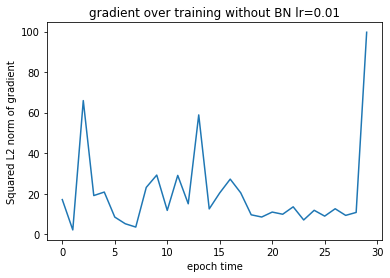

In [ ]:
plt.plot(np.arange(len(grads_list)), grads_list)

plt.xlabel('epoch time') 
plt.ylabel('Squared L2 norm of gradient') 
plt.title('gradient over training without BN lr=0.01') 

In [ ]:
# Test the model
model_noBN.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_noBN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 67.3 %


The graph shows really bad training process for gradient after removing batch normalization and set learning rate to 0.01. Most interestingly, after 26 epochs, the gradeint starts to explode. It caused the accuracy of model to decrease to 67.3%.

Next, change the learning rate to 0.001, which is smaller than the original value

In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.001
model_noBN = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_noBN.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_noBN(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    grads = 0
    for w in model_noBN.parameters():
      grad = w.grad.cpu().detach().numpy()
      grad = np.sum(np.sum(grad*grad))
      grads+=grad
    grads_list.append(grads)

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 2.0610
Epoch [1/30], Step [200/500] Loss: 1.8553
Epoch [1/30], Step [300/500] Loss: 1.9328
Epoch [1/30], Step [400/500] Loss: 1.7916
Epoch [1/30], Step [500/500] Loss: 1.5701
Epoch [2/30], Step [100/500] Loss: 1.7058
Epoch [2/30], Step [200/500] Loss: 1.7016
Epoch [2/30], Step [300/500] Loss: 1.6316
Epoch [2/30], Step [400/500] Loss: 1.3670
Epoch [2/30], Step [500/500] Loss: 1.4215
Epoch [3/30], Step [100/500] Loss: 1.4328
Epoch [3/30], Step [200/500] Loss: 1.2795
Epoch [3/30], Step [300/500] Loss: 1.2647
Epoch [3/30], Step [400/500] Loss: 1.3373
Epoch [3/30], Step [500/500] Loss: 1.3580
Epoch [4/30], Step [100/500] Loss: 1.1234
Epoch [4/30], Step [200/500] Loss: 1.1909
Epoch [4/30], Step [300/500] Loss: 1.1608
Epoch [4/30], Step [400/500] Loss: 1.3336
Epoch [4/30], Step [500/500] Loss: 0.9812
Epoch [5/30], Step [100/500] Loss: 1.0029
Epoch [5/30], Step [200/500] Loss: 1.0869
Epoch [5/30], Step [300/500] Loss: 1.0114
Epoch [5/30], Step [400/500] Loss:

Text(0.5, 1.0, 'gradient over training without BN lr=0.001')

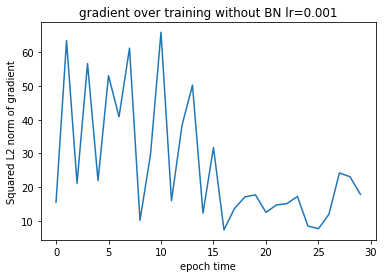

In [ ]:
plt.plot(np.arange(len(grads_list)), grads_list)

plt.xlabel('epoch time') 
plt.ylabel('Squared L2 norm of gradient') 
plt.title('gradient over training without BN lr=0.001') 

In [ ]:
# Test the model
model_noBN.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_noBN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 83.07 %


The graph shows that even though the square L2 norm of graident is still large, teh graident is going to converge after 30 epochs. Also, the accuracy of this model is 83%, which outperforms than previous two models. That means if we do not use batch normalization, it may caus gradient explosion. In order to achieve the high accuracy as before, we need to decrease the learning rate.

# 2. Residual connections (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

First, remove the residual connection in the residual block

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.003
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 1.8245
Epoch [1/30], Step [200/500] Loss: 1.5738
Epoch [1/30], Step [300/500] Loss: 1.4854
Epoch [1/30], Step [400/500] Loss: 1.5159
Epoch [1/30], Step [500/500] Loss: 1.3957
Epoch [2/30], Step [100/500] Loss: 1.1873
Epoch [2/30], Step [200/500] Loss: 1.3654
Epoch [2/30], Step [300/500] Loss: 1.0772
Epoch [2/30], Step [400/500] Loss: 1.2293
Epoch [2/30], Step [500/500] Loss: 1.1941
Epoch [3/30], Step [100/500] Loss: 0.8888
Epoch [3/30], Step [200/500] Loss: 0.8685
Epoch [3/30], Step [300/500] Loss: 0.9926
Epoch [3/30], Step [400/500] Loss: 1.0138
Epoch [3/30], Step [500/500] Loss: 0.7935
Epoch [4/30], Step [100/500] Loss: 0.7184
Epoch [4/30], Step [200/500] Loss: 0.9695
Epoch [4/30], Step [300/500] Loss: 0.7691
Epoch [4/30], Step [400/500] Loss: 0.9182
Epoch [4/30], Step [500/500] Loss: 0.7413
Epoch [5/30], Step [100/500] Loss: 0.8781
Epoch [5/30], Step [200/500] Loss: 0.6631
Epoch [5/30], Step [300/500] Loss: 0.6717
Epoch [5/30], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 86.29 %


Next, add the residual connection around a single convolution/nonlinearity combination. That means, instead of only one residual connection in the original model, now there are two connections in the residual block.

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample1=None, downsample2 = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample1 = downsample1
        self.downsample2 = downsample2



    def forward(self, x):
        residual1 = x
        residual2 = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.downsample1:
            residual1 = self.downsample1(x)
        out += residual1
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample2:
            residual2 = self.downsample2(x)
        out += residual2
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample1 = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample1 = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        downsample2 = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample2 = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample1, downsample2))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
#tune hyperparameters
num_epochs = 30
learning_rate = 0.003
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
grads_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [100/500] Loss: 1.7824
Epoch [1/30], Step [200/500] Loss: 1.4379
Epoch [1/30], Step [300/500] Loss: 1.5957
Epoch [1/30], Step [400/500] Loss: 1.4454
Epoch [1/30], Step [500/500] Loss: 1.0351
Epoch [2/30], Step [100/500] Loss: 1.1158
Epoch [2/30], Step [200/500] Loss: 1.1964
Epoch [2/30], Step [300/500] Loss: 1.0401
Epoch [2/30], Step [400/500] Loss: 1.0221
Epoch [2/30], Step [500/500] Loss: 1.0145
Epoch [3/30], Step [100/500] Loss: 1.0128
Epoch [3/30], Step [200/500] Loss: 0.6689
Epoch [3/30], Step [300/500] Loss: 0.7830
Epoch [3/30], Step [400/500] Loss: 0.9123
Epoch [3/30], Step [500/500] Loss: 0.8835
Epoch [4/30], Step [100/500] Loss: 0.9827
Epoch [4/30], Step [200/500] Loss: 0.7392
Epoch [4/30], Step [300/500] Loss: 0.5494
Epoch [4/30], Step [400/500] Loss: 0.5752
Epoch [4/30], Step [500/500] Loss: 0.7904
Epoch [5/30], Step [100/500] Loss: 0.5245
Epoch [5/30], Step [200/500] Loss: 0.7775
Epoch [5/30], Step [300/500] Loss: 0.7565
Epoch [5/30], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    count = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        count += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * count / total))

Accuracy of the model on the test images: 87.36 %


The results of these two models show that: after removing redisual connections, the accuracy of model indeed reducued, but very litte amount (from 87.98% to 86.29%). The reason for that might be that I only use 30 epochs for training, and that is not enough for the gradient vaishing to happen. Also, after I add one more residual connection in the residual block, the accuracy of model did increase to 87.36%, which is very close to that of original model. Still, if I change the epoch size to 100 or more, this two-connection resnet must outperform the original one, because it can better solve the problem of gradient vanishing.